<a href="https://colab.research.google.com/github/harshad317/harshad317-Silicon_Valley_21st_Century_Education_Hackathon/blob/main/Silicon_Valley_21st_Century_Education_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install optuna
#!pip install catboost
#!pip install feature_engine
#!pip install category_encoders
#!pip install rfpimp
#!pip install interpret

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer, StandardScaler, RobustScaler, KBinsDiscretizer, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit, KFold, GridSearchCV, RepeatedKFold
from itertools import combinations
from tqdm.notebook import tqdm
from rfpimp import permutation_importances
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
import optuna
from category_encoders import CatBoostEncoder, LeaveOneOutEncoder, BinaryEncoder, JamesSteinEncoder, WOEEncoder, TargetEncoder
from scipy.stats import chi2_contingency
from feature_engine.encoding import PRatioEncoder, MeanEncoder
from sklearn.decomposition import NMF
from rfpimp import permutation_importances
from feature_engine.outliers import Winsorizer
from scipy.stats import spearmanr

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sample = pd.read_csv('SampleSubmission.csv')

ID : Unique ID

CountryCode : Country Code

region_code :  Region Code

year : Year

sex : Sex

agefrom : Starting Age

ageto : Finishing Age

percentage_no_schooling : Percentage of No Schooling Attained in Pop.

percentage_primary_schooling : Percentage of Primary Schooling Attained in Pop.

percentage_primary_schooling_completed : Percentage of Complete Primary 
Schooling Attained in Pop.

percentage_secondary_schooling : Percentage of Secondary Schooling Attained in Pop.

percentage_secondary_schooling_completed : Percentage of Complete Secondary Schooling Attained in Pop.

percentage_tertiary_schooling : Percentage of Tertiary Schooling Attained in Pop.

percentage_tertiary_schooling_completed : Percentage of Complete Tertiary Schooling Attained in Pop.

yr_sch : Average Years of Schooling Attained

literate_pop : Literate population

target = LR : Literacy rate (in percentage)

In [ ]:
train = train.drop(['ageto'], axis= 1)
test = test.drop(['ageto'], axis= 1)

In [ ]:
train.shape, test.shape

((14016, 16), (1168, 15))

In [ ]:
train.head()

,ID,countryCode,year,sex,agefrom,percentage_no_schooling,percentage_primary_schooling,percentage_primary_schooling_completed,percentage_secondary_schooling,percentage_secondary_schooling_completed,percentage_tertiary_schooling,percentage_tertiary_schooling_completed,yr_sch,region_code,literate_pop,target
0,ID_00AMK8K,155,1990,MF,15,8.3900,26.270000,15.830000,58.570000,26.420000,6.770000,4.400000,8.540000,Latin America and the Caribbean,7435.0,91.609167
1,ID_00ANS9C,115,2005,MF,25,0.6325,6.980833,6.363333,77.683333,49.995833,14.700833,13.546667,11.631667,Europe and Central Asia,14350.0,99.362969
2,ID_00AQU1S,30,2000,M,15,68.5300,26.320000,16.020000,4.620000,2.320000,0.540000,0.310000,1.550000,Sub-Saharan Africa,1458.0,31.469890
3,ID_00AVQ7Q,143,1960,MF,15,12.5300,69.370000,49.260000,8.130000,1.100000,9.970000,5.510000,7.490000,Latin America and the Caribbean,45.0,86.538462
4,ID_00BAH2C,70,1955,MF,25,20.9800,55.900000,22.380000,20.850000,10.240000,2.270000,1.950000,4.890000,Latin America and the Caribbean,2380.0,79.017264


In [ ]:
ids = test.ID

In [ ]:
df = pd.concat([train, test], axis= 0)

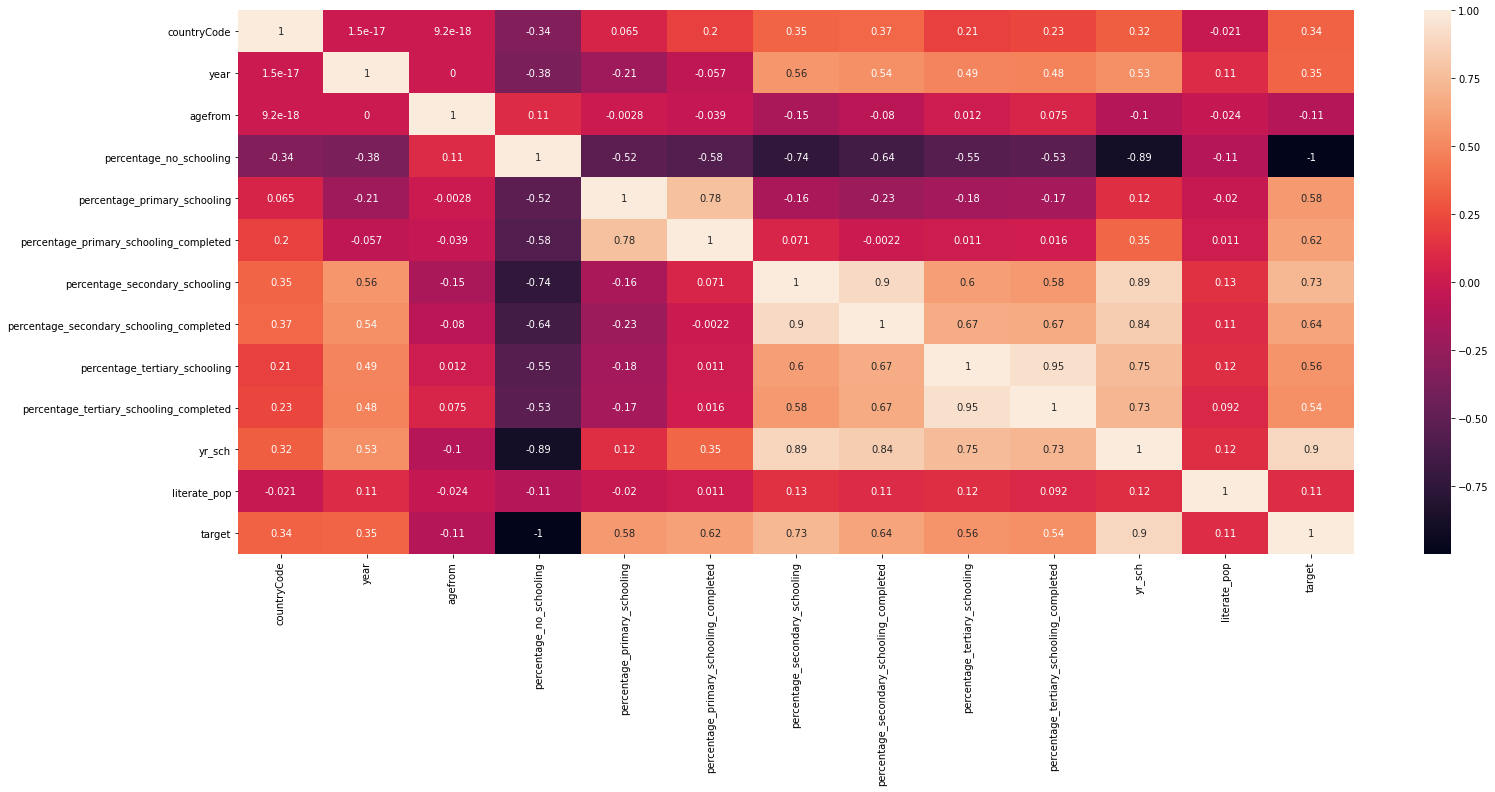

In [ ]:
plt.figure(figsize=(25,10))
sns.heatmap(df.corr(), annot= True)

In [ ]:
#df['country+year']= df.countryCode + df.year
#df['country-year']= df.countryCode - df.year
#df['country*year']= df.countryCode * df.year
#df['country/year']= df.countryCode / df.year

In [ ]:
df.head()

,ID,countryCode,year,sex,agefrom,percentage_no_schooling,percentage_primary_schooling,percentage_primary_schooling_completed,percentage_secondary_schooling,percentage_secondary_schooling_completed,percentage_tertiary_schooling,percentage_tertiary_schooling_completed,yr_sch,region_code,literate_pop,target
0,ID_00AMK8K,155,1990,MF,15,8.3900,26.270000,15.830000,58.570000,26.420000,6.770000,4.400000,8.540000,Latin America and the Caribbean,7435.0,91.609167
1,ID_00ANS9C,115,2005,MF,25,0.6325,6.980833,6.363333,77.683333,49.995833,14.700833,13.546667,11.631667,Europe and Central Asia,14350.0,99.362969
2,ID_00AQU1S,30,2000,M,15,68.5300,26.320000,16.020000,4.620000,2.320000,0.540000,0.310000,1.550000,Sub-Saharan Africa,1458.0,31.469890
3,ID_00AVQ7Q,143,1960,MF,15,12.5300,69.370000,49.260000,8.130000,1.100000,9.970000,5.510000,7.490000,Latin America and the Caribbean,45.0,86.538462
4,ID_00BAH2C,70,1955,MF,25,20.9800,55.900000,22.380000,20.850000,10.240000,2.270000,1.950000,4.890000,Latin America and the Caribbean,2380.0,79.017264


In [ ]:
df.countryCode.min()

NameError: ignored

In [ ]:
df['actual_primary'] = df.percentage_primary_schooling - df.percentage_primary_schooling_completed
df['actual_secondary'] = df.percentage_secondary_schooling - df.percentage_secondary_schooling_completed
df['actual_tertiary'] = df.percentage_tertiary_schooling - df.percentage_tertiary_schooling_completed

In [ ]:
df['total'] = df.actual_primary + df.actual_secondary + df.actual_tertiary
df['real_deal'] = df.total - df.percentage_no_schooling

In [ ]:
df['lets_see']= df.literate_pop - (df.literate_pop * df.total)/100

In [ ]:
'''df['country_by_year'] = df.countryCode.astype(str) + '_' + df.year.astype(str)
df['country_by_sex'] = df.countryCode.astype(str) + '_' + df.sex.astype(str)
df['country_by_agefrom'] = df.countryCode.astype(str) + '_' + df.agefrom.astype(str)
df['country_by_region'] = df.countryCode.astype(str) + '_' + df.region_code.astype(str)
df['year_by_sex'] = df.year.astype(str) + '_' + df.sex.astype(str)
df['year_by_agefrom'] = df.year.astype(str) + '_' + df.agefrom.astype(str)
df['year_by_region'] = df.year.astype(str) + '_' + df.region_code.astype(str)
df['sex_by_agefrom'] = df.sex.astype(str) + '_' + df.agefrom.astype(str)
df['sex_by_region'] = df.sex.astype(str) + '_' + df.region_code.astype(str)'''

In [ ]:
df['literate_by_country_mean']= df.groupby(['countryCode'])['literate_pop'].transform('mean')
df['literate_by_country_median']= df.groupby(['countryCode'])['literate_pop'].transform('median')

In [ ]:
df.region_code.unique()

array(['Latin America and the Caribbean', 'Europe and Central Asia',
       'Sub-Saharan Africa', 'East Asia and the Pacific', 'South Asia',
       'Advanced Economies', 'Middle East and North Africa'], dtype=object)

In [ ]:
reg = pd.get_dummies(df.region_code, drop_first=True, prefix = 'reg_')
df = df.drop('region_code', axis= 1)
df = pd.concat([df,reg], axis= 1)

In [ ]:
sex = pd.get_dummies(df.sex, drop_first=True, prefix= 'sex_')
df = df.drop('sex', axis= 1)
df = pd.concat([df,sex], axis= 1)

In [ ]:
age = pd.get_dummies(df.agefrom, drop_first=True, prefix= 'age_')
df = df.drop('agefrom', axis= 1)
df = pd.concat([df,age], axis= 1)

In [ ]:
[var for var in df.columns if df[var].dtypes == 'O']

['ID']

In [ ]:
cat_cols = ['countryCode',
 'year',
 'agefrom',
 'country_by_year',
 'country_by_sex',
 'country_by_agefrom',
 'country_by_region',
 'year_by_sex',
 'year_by_agefrom',
 'year_by_region',
 'sex_by_agefrom',
 'sex_by_region']

In [ ]:
[var for var in df.columns if df[var].dtypes != 'O']

['countryCode',
 'year',
 'agefrom',
 'percentage_no_schooling',
 'percentage_primary_schooling',
 'percentage_primary_schooling_completed',
 'percentage_secondary_schooling',
 'percentage_secondary_schooling_completed',
 'percentage_tertiary_schooling',
 'percentage_tertiary_schooling_completed',
 'yr_sch',
 'literate_pop',
 'target']

In [ ]:
cont_cols = ['countryCode',
 'year',
 'agefrom',
 'percentage_no_schooling',
 'percentage_primary_schooling',
 'percentage_primary_schooling_completed',
 'percentage_secondary_schooling',
 'percentage_secondary_schooling_completed',
 'percentage_tertiary_schooling',
 'percentage_tertiary_schooling_completed',
 'yr_sch',
 'literate_pop']

In [ ]:
train = df[:14016]
test = df[14016:]

In [ ]:
from category_encoders import BinaryEncoder, JamesSteinEncoder

be = JamesSteinEncoder(sigma=0.1)
train[cat_cols] = be.fit_transform(train[cat_cols], train['target'])
test[cat_cols] = be.transform(test[cat_cols])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
X_train = train[cont_cols]
y_train = train['target']
X_test = test[cont_cols]

In [ ]:
lgbm_param = {'reg_lambda': 1.0879346904638683,
 'reg_alpha': 2.317557821178951,
 'colsample_bytree': 1.0,
 'subsample': 0.7,
 'learning_rate': 0.09985870233548036,
 'max_depth': 15,
 'min_child_weight': 8}

In [ ]:
RandomForestRegressor()

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
n_folds = 10
subbed = []
kf = KFold(n_splits=n_folds, shuffle=True, random_state=10)


for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
    print('=============== Fold No:',fold+1,'===============')
    X_tr, X_tst = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_tst = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    model = XGBRegressor(n_estimators=4841,eval_metric= 'mae', objective='reg:squarederror')
    model.fit(X_tr, y_tr,eval_set=[(X_tst, y_tst)],verbose=1000)
    print(mean_absolute_error(y_tst, model.predict(X_tst)))
    subbed.append(mean_absolute_error(y_tst, model.predict(X_tst)))
    pred = model.predict(X_test)
print(np.mean(subbed))

=============== Fold No: 1 ===============
[0]	validation_0-mae:57.597
[1000]	validation_0-mae:0.134035
[2000]	validation_0-mae:0.113918
[3000]	validation_0-mae:0.107668
[4000]	validation_0-mae:0.105244
[4840]	validation_0-mae:0.103024
0.10302370584320943
=============== Fold No: 2 ===============
[0]	validation_0-mae:59.6604
[1000]	validation_0-mae:0.136628
[2000]	validation_0-mae:0.118445
[3000]	validation_0-mae:0.11202
[4000]	validation_0-mae:0.109505
[4840]	validation_0-mae:0.108205
0.10820465460895122
=============== Fold No: 3 ===============
[0]	validation_0-mae:58.2994
[1000]	validation_0-mae:0.123902
[2000]	validation_0-mae:0.107
[3000]	validation_0-mae:0.101438
[4000]	validation_0-mae:0.098399
[4840]	validation_0-mae:0.096598
0.09659799247246714
=============== Fold No: 4 ===============
[0]	validation_0-mae:57.4813
[1000]	validation_0-mae:0.135097
[2000]	validation_0-mae:0.116126
[3000]	validation_0-mae:0.110303
[4000]	validation_0-mae:0.108106
[4840]	validation_0-mae:0.1070

In [ ]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df):
    plt.figure(figsize=(15,10))
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue')

In [ ]:
def r2(rf, X_train, y_train):
    return mean_absolute_error(y_train, model.predict(X_train))

perm_imp_rfpimp = permutation_importances(model, X_train, y_train, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)

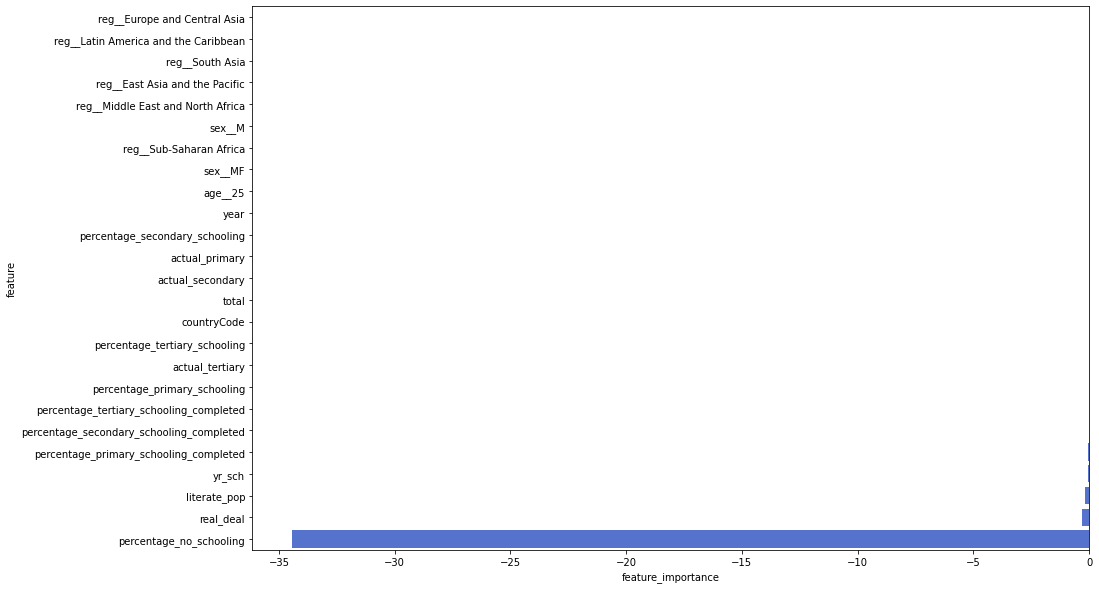

In [ ]:
var_imp_plot(perm_imp_rfpimp)

In [ ]:
#model = XGBRegressor(eval_metric= 'mae', objective='reg:squarederror', **param)
#model.fit(X_tr, y_tr,eval_set=[(X_tst, y_tst)], early_stopping_rounds=50,verbose=100)

In [ ]:
X = train[cont_cols]
y = train['target']

In [ ]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    
    # To select which parameters to optimize, please look at the XGBoost documentation:
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    param = {
        #'objective': 'regression',
        #'tree_method':'gpu_hist',  # Use GPU acceleration
        'reg_lambda': trial.suggest_loguniform(
            'reg_lambda', 1e-3, 10.0
        ),
        'reg_alpha': trial.suggest_loguniform(
            'reg_alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'learning_rate': trial.suggest_loguniform(
            'learning_rate', 1e-5, 1e-1
        ),
        'max_depth': trial.suggest_int(
            'max_depth', 2,50
        ),
        'random_state': 2021,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
    }
    n_folds = 10
    subbed = []
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=10)


    for fold, (train_idx, test_idx) in enumerate(kf.split(train_x, train_y)):
        #print('=============== Fold No:',fold+1,'===============')
        X_tr, X_tst = train_x.iloc[train_idx], train_x.iloc[test_idx]
        y_tr, y_tst = train_y.iloc[train_idx], train_y.iloc[test_idx]
    
        model = LGBMRegressor(metric= 'l1', **param)
        model.fit(X_tr, y_tr,eval_set=[(X_tst, y_tst)], early_stopping_rounds=50,verbose=100)
        #print(r2_score(y_tst, model.predict(X_tst)))
        subbed.append(mean_absolute_error(y_tst, model.predict(X_tst)))
    return (np.mean(subbed))

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-06-30 17:50:04,007] A new study created in memory with name: no-name-9f28fee1-d398-42df-a9b8-672899d4e90a


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 27.008
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 27.008
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.0962
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.0962
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.9378
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.9378
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.7101
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.7101
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.1686
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.1686
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.0137
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.0137
Traini

[I 2021-06-30 17:50:05,864] Trial 0 finished with value: 26.424690044904953 and parameters: {'reg_lambda': 0.5190118393155492, 'reg_alpha': 0.02041470640914184, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.00015536658106972366, 'max_depth': 45, 'min_child_weight': 231}. Best is trial 0 with value: 26.424690044904953.


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.4872
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.4872
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 27.2671
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 27.2671
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.3469
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.3469
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 27.1969
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 27.1969
[LightGBM] [Warning] Accuracy 

[I 2021-06-30 17:50:07,925] Trial 1 finished with value: 26.67789860319109 and parameters: {'reg_lambda': 3.0640139807806888, 'reg_alpha': 0.5811820186651494, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 5.687876686183363e-05, 'max_depth': 28, 'min_child_weight': 31}. Best is trial 0 with value: 26.424690044904953.


[100]	valid_0's l1: 26.741
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.741
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.7982
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.7982
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 25.8934
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 25.8934
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.7301
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.7301
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num

[I 2021-06-30 17:50:10,623] Trial 2 finished with value: 26.21932166673951 and parameters: {'reg_lambda': 0.10939400536082493, 'reg_alpha': 0.004205534470543025, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.00022985025922795025, 'max_depth': 23, 'min_child_weight': 69}. Best is trial 2 with value: 26.21932166673951.


[100]	valid_0's l1: 26.2803
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.2803
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 27.3328
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 27.3328
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.4105
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.4105
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 27.2628
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 27.2628
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > n

[I 2021-06-30 17:50:12,421] Trial 3 finished with value: 26.742383001963965 and parameters: {'reg_lambda': 2.155296080335089, 'reg_alpha': 0.24575510543676912, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 3.2538018755077955e-05, 'max_depth': 9, 'min_child_weight': 230}. Best is trial 2 with value: 26.21932166673951.


[100]	valid_0's l1: 26.8053
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.8053
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 27.1478
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 27.1478
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.2318
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.2318
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 27.0779
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 27.0779
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.8494
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.8494
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.3036
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.3036
Training until validation scores don't improve for 50 rounds.
[100

[I 2021-06-30 17:50:14,650] Trial 4 finished with value: 26.561278694234698 and parameters: {'reg_lambda': 0.24592518012201012, 'reg_alpha': 0.008790967124229039, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.00010136550758014449, 'max_depth': 49, 'min_child_weight': 81}. Best is trial 2 with value: 26.21932166673951.


[100]	valid_0's l1: 26.6238
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.6238
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 11.4517
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 11.4517
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 11.1342
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 11.1342
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 11.4711
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 11.4711
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 11.3597
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 11.3597
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 11.1495
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 11.1495
Training until validation scores don't improve for 50 rounds.
[100

[I 2021-06-30 17:50:15,560] Trial 5 finished with value: 11.25642414410977 and parameters: {'reg_lambda': 0.0037315956018515, 'reg_alpha': 0.02811871001774426, 'colsample_bytree': 0.9, 'subsample': 0.9, 'learning_rate': 0.009267917195016814, 'max_depth': 2, 'min_child_weight': 86}. Best is trial 5 with value: 11.25642414410977.


[100]	valid_0's l1: 11.2469
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 11.2469
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 23.5761
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.5761
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 22.7756
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.7756
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 23.5058
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.5058
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > n

[I 2021-06-30 17:50:17,259] Trial 6 finished with value: 23.067230748577824 and parameters: {'reg_lambda': 6.5883114602673984, 'reg_alpha': 0.013533268871879228, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.0015551597419046696, 'max_depth': 6, 'min_child_weight': 84}. Best is trial 5 with value: 11.25642414410977.


[100]	valid_0's l1: 23.1743
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.1743
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 23.1333
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.1333
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 27.3557
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 27.3557
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.433
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.433
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num

[I 2021-06-30 17:50:19,782] Trial 7 finished with value: 26.764848978075683 and parameters: {'reg_lambda': 0.001435987592486815, 'reg_alpha': 0.003498922501318475, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 2.4084535710689678e-05, 'max_depth': 22, 'min_child_weight': 81}. Best is trial 5 with value: 11.25642414410977.


[100]	valid_0's l1: 26.8276
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.8276
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 3.64186
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 3.64186
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 3.52485
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 3.52485
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 3.64665
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 3.64665
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 3.61029
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 3.61029
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 3.53464
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 3.53464
Training until validation scores don't improve for 50 rounds.
[100

[I 2021-06-30 17:50:21,703] Trial 8 finished with value: 3.5720544684326696 and parameters: {'reg_lambda': 6.667064664851027, 'reg_alpha': 0.0771268484927327, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.02020273830569781, 'max_depth': 40, 'min_child_weight': 108}. Best is trial 8 with value: 3.5720544684326696.


[100]	valid_0's l1: 3.58238
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 3.58238
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.6055
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.6055
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 25.7199
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 25.7199
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.5413
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.5413
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.3163
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.3163
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 25.7808
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 25.7808
Training until validation scores don't improve for 50 rounds.
[100

[I 2021-06-30 17:50:22,504] Trial 9 finished with value: 26.036441654931167 and parameters: {'reg_lambda': 0.0049979860724186495, 'reg_alpha': 0.6821081368878383, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.00034688825071374474, 'max_depth': 2, 'min_child_weight': 90}. Best is trial 8 with value: 3.5720544684326696.


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.1481
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.1481
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.0961
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.0961
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.155534
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.155534
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.159937
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.159937
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.167563
Did not meet early stopping. Best iteration is:
[94]	valid_0's l1: 0.167478
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.175066
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.1750

[I 2021-06-30 17:50:24,357] Trial 10 finished with value: 0.16177712479589715 and parameters: {'reg_lambda': 0.017885928544213663, 'reg_alpha': 8.050833098630621, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.08912110408600439, 'max_depth': 38, 'min_child_weight': 150}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 0.149247
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.149247
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.156729
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.156661
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.165371
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.165371
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.170738
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.170738
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.17776
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.17776
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.158313
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.158313
Training until validation scores don't improve for 50 rou

[I 2021-06-30 17:50:26,198] Trial 11 finished with value: 0.1641425591157723 and parameters: {'reg_lambda': 0.017932420358783757, 'reg_alpha': 8.060846180551106, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.09070253276390423, 'max_depth': 38, 'min_child_weight': 162}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 0.164613
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.164596
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.151928
Did not meet early stopping. Best iteration is:
[98]	valid_0's l1: 0.151892
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.161324
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.161324
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.168212
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.168212
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.17305
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.17305
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.186581
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.186581
Training until validation scores don't improve for 50 roun

[I 2021-06-30 17:50:27,970] Trial 12 finished with value: 0.16897841837464428 and parameters: {'reg_lambda': 0.013279088236096977, 'reg_alpha': 8.271264850082014, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.06985066299905325, 'max_depth': 36, 'min_child_weight': 171}. Best is trial 10 with value: 0.16177712479589715.


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.156858
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.156858
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.601059
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.601059
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.579942
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.579942
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.613991
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.613991
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.648068
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.648068
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.638801
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0

[I 2021-06-30 17:50:29,915] Trial 13 finished with value: 0.6206102559588915 and parameters: {'reg_lambda': 0.027612936049131252, 'reg_alpha': 9.907089229128202, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.08873419936646543, 'max_depth': 32, 'min_child_weight': 172}. Best is trial 10 with value: 0.16177712479589715.


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.61789
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.61789
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 9.46084
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 9.46084
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 9.13046
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 9.13046
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 9.43844
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 9.43844
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 9.34436
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 9.34436
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 9.16116
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 9.16116
Trai

[I 2021-06-30 17:50:31,951] Trial 14 finished with value: 9.25098891536466 and parameters: {'reg_lambda': 0.028709259603812907, 'reg_alpha': 2.841214702036926, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.010615436626880864, 'max_depth': 41, 'min_child_weight': 290}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 9.27728
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 9.27728
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.719873
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.719873
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.722569
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.722569
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.73348
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.73348
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth

[I 2021-06-30 17:50:34,221] Trial 15 finished with value: 0.7241421067281595 and parameters: {'reg_lambda': 0.00120853489511701, 'reg_alpha': 2.7204979294662257, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.03601927578900236, 'max_depth': 16, 'min_child_weight': 140}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 0.719772
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.719772
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 21.5052
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.5052
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 20.7765
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 20.7765
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 21.4524
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.4524
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 21.2742
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.2742
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 20.836
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 20.836
Training until validation scores don't improve for 50 rounds.
[100

[I 2021-06-30 17:50:36,424] Trial 16 finished with value: 21.040481391258957 and parameters: {'reg_lambda': 0.05560703938668636, 'reg_alpha': 3.201222310986892, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.0024294910832532526, 'max_depth': 48, 'min_child_weight': 201}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 21.0877
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 21.0877
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 18.4462
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 18.4462
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 17.8541
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 17.8541
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 18.3727
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 18.3727
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 18.2312
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 18.2312
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 17.8701
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 17.8701
Training until validation scores don't improve for 50 rounds.
[100

[I 2021-06-30 17:50:38,341] Trial 17 finished with value: 18.05642032850462 and parameters: {'reg_lambda': 0.009342098644421148, 'reg_alpha': 0.0010692611511971468, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.004160752398751222, 'max_depth': 34, 'min_child_weight': 136}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 18.1007
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 18.1007
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.651136
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.651136
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.645135
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.645135
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.664391
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.664391
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.705102
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.705102
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.69069
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.69069
Training until validation scores don't improve for 50 roun

[I 2021-06-30 17:50:40,251] Trial 18 finished with value: 0.6843428329851907 and parameters: {'reg_lambda': 0.1796525857116626, 'reg_alpha': 1.1213259307077013, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.07870790367252235, 'max_depth': 40, 'min_child_weight': 286}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 0.702431
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.702431
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 1.66064
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.66064
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 1.62509
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.62509
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 1.67421
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.67421
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth >

[I 2021-06-30 17:50:42,527] Trial 19 finished with value: 1.6471211396229617 and parameters: {'reg_lambda': 0.004476993542382923, 'reg_alpha': 7.2305694903959035, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.02770234886967726, 'max_depth': 29, 'min_child_weight': 1}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 1.64782
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.64782
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 25.7164
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 25.7164
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 24.8474
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 24.8474
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 25.6534
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 25.6534
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 25.4362
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 25.4362
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 24.9189
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 24.9189
Training until validation scores don't improve for 50 rounds.
[100

[I 2021-06-30 17:50:45,017] Trial 20 finished with value: 25.161908313481412 and parameters: {'reg_lambda': 0.025530563195025495, 'reg_alpha': 0.11875185718453186, 'colsample_bytree': 1.0, 'subsample': 0.9, 'learning_rate': 0.0006414941592469576, 'max_depth': 44, 'min_child_weight': 213}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 25.221
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 25.221
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.235107
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.235107
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.243672
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.243672
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.244045
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.244045
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.271626
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.271626
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.236959
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.236959
Training until validation scores don't improve for 50 roun

[I 2021-06-30 17:50:46,822] Trial 21 finished with value: 0.24628516665289557 and parameters: {'reg_lambda': 0.010182226162543745, 'reg_alpha': 9.515486199240634, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.05011952830152796, 'max_depth': 35, 'min_child_weight': 173}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 0.244002
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.244002
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.237763
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.237763
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.157702
Did not meet early stopping. Best iteration is:
[98]	valid_0's l1: 0.157629
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.161472
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.161472
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.168004
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.168004
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.176315
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.176315
Training until validation scores don't improve for 50 r

[I 2021-06-30 17:50:48,767] Trial 22 finished with value: 0.16293651761001077 and parameters: {'reg_lambda': 0.012772727802420343, 'reg_alpha': 5.417688714350543, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.09288523589667728, 'max_depth': 35, 'min_child_weight': 169}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 0.153127
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.153127
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 5.91365
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 5.91365
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 5.72259
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 5.72259
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 5.90984
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 5.90984
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 5.85827
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 5.85827
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 5.74301
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 5.74301
Training until validation scores don't improve for 50 rounds.
[1

[I 2021-06-30 17:50:51,054] Trial 23 finished with value: 5.7954264514094485 and parameters: {'reg_lambda': 0.08251959855473277, 'reg_alpha': 4.072460439440432, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.015242245196246293, 'max_depth': 38, 'min_child_weight': 121}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 5.80956
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 5.80956
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.159497
Did not meet early stopping. Best iteration is:
[96]	valid_0's l1: 0.159255
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.163115
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.163115
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.170162
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.170162
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.176317
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.176317
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.159023
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.159023
Training until validation scores don't improve for 50 rou

[I 2021-06-30 17:50:53,371] Trial 24 finished with value: 0.1646016757304547 and parameters: {'reg_lambda': 0.002562168488178412, 'reg_alpha': 1.3864694563732751, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.0884045983187427, 'max_depth': 31, 'min_child_weight': 193}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 0.154555
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.154555
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 16.5707
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 16.5707
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 15.997
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 15.997
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 16.5292
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 16.5292
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 16.3788
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 16.3788
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 16.0556
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 16.0556
Training until validation scores don't improve for 50 rounds.
[100

[I 2021-06-30 17:50:55,469] Trial 25 finished with value: 16.20968393397555 and parameters: {'reg_lambda': 0.02011825393017711, 'reg_alpha': 4.780150153681957, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.005032265513544389, 'max_depth': 45, 'min_child_weight': 250}. Best is trial 10 with value: 0.16177712479589715.


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 16.2575
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 16.2575
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 1.19813
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.19813
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 1.20517
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.20517
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 1.20743
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.20743
[LightGBM] [Warning] Accuracy 

[I 2021-06-30 17:50:57,489] Trial 26 finished with value: 1.2188415344346715 and parameters: {'reg_lambda': 0.05041618753941389, 'reg_alpha': 2.0630890838956697, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.037119084623434426, 'max_depth': 24, 'min_child_weight': 161}. Best is trial 10 with value: 0.16177712479589715.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 1.25536
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.25536
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 27.3943
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 27.3943
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.4704
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.4704
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 27.3242
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 27.3242
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 27.0936
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 27.0936
Training until validation scores don't improve for 50 rounds.
[100]	

[I 2021-06-30 17:50:59,356] Trial 27 finished with value: 26.80270051643488 and parameters: {'reg_lambda': 0.007774599445625467, 'reg_alpha': 0.402136010110414, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 1.0161754834289834e-05, 'max_depth': 43, 'min_child_weight': 147}. Best is trial 10 with value: 0.16177712479589715.


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.8656
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.8656
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.612219
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.612219
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.6076
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.6076
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.610543
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.610543
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.643167
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.643167
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.650404
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.65040

[I 2021-06-30 17:51:01,387] Trial 28 finished with value: 0.6265233048908735 and parameters: {'reg_lambda': 0.0025242493264571, 'reg_alpha': 9.96058283452019, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.04584538619765249, 'max_depth': 37, 'min_child_weight': 112}. Best is trial 10 with value: 0.16177712479589715.


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.544765
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.544765
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.53984
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.53984
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.56558
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.56558
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.595515
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.595515
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.595511
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.595511
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.610612
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.610

[I 2021-06-30 17:51:03,417] Trial 29 finished with value: 0.5720872835977666 and parameters: {'reg_lambda': 0.5952487192163048, 'reg_alpha': 1.3023827272265456, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.09389576777732637, 'max_depth': 49, 'min_child_weight': 254}. Best is trial 10 with value: 0.16177712479589715.


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 13.5464
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 13.5464
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 13.1119
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 13.1119
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 13.4821
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 13.4821
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 13.376
Did n

[I 2021-06-30 17:51:05,291] Trial 30 finished with value: 13.264363940872595 and parameters: {'reg_lambda': 0.05601867005916947, 'reg_alpha': 5.357526731131669, 'colsample_bytree': 0.7, 'subsample': 0.9, 'learning_rate': 0.007206526253619036, 'max_depth': 20, 'min_child_weight': 193}. Best is trial 10 with value: 0.16177712479589715.


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 13.3102
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 13.3102
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.159295
Did not meet early stopping. Best iteration is:
[90]	valid_0's l1: 0.159202
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.162281
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.162281
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.170748
Did not meet early stopping. Best iteration is:
[98]	valid_0's l1: 0.170722
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.175668
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.175668
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.158204
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.158

[I 2021-06-30 17:51:07,535] Trial 31 finished with value: 0.1639078926088559 and parameters: {'reg_lambda': 0.014957359103251728, 'reg_alpha': 1.5987115826485685, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.09615910391155254, 'max_depth': 31, 'min_child_weight': 188}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 0.152801
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.152801
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 3.63465
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 3.63465
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 3.52337
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 3.52337
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 3.63886
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 3.63886
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth >

[I 2021-06-30 17:51:09,710] Trial 32 finished with value: 3.5687051335759152 and parameters: {'reg_lambda': 0.014535503276515146, 'reg_alpha': 1.684986232021241, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.020022754338373708, 'max_depth': 27, 'min_child_weight': 219}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 3.57302
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 3.57302
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.157667
Did not meet early stopping. Best iteration is:
[94]	valid_0's l1: 0.157355
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.16299
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.162954
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.167641
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.167641
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.175062
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.175062
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.158504
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.158504
Training until validation scores don't improve for 50 round

[I 2021-06-30 17:51:12,095] Trial 33 finished with value: 0.1630042670156733 and parameters: {'reg_lambda': 0.006807813240522407, 'reg_alpha': 0.793821497901841, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.09333381736665597, 'max_depth': 32, 'min_child_weight': 185}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 0.152823
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.152752
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.181387
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.181387
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.186541
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.186541
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.189136
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.189136
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.209836
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.209836
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.180482
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.180482
Training until validation scores don't improve for 50 r

[I 2021-06-30 17:51:14,469] Trial 34 finished with value: 0.18911736254206002 and parameters: {'reg_lambda': 0.005708529910299363, 'reg_alpha': 0.6774527125324872, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.057072103439291776, 'max_depth': 31, 'min_child_weight': 182}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 0.18082
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.18082
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 1.36415
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.36415
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 1.32226
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.32226
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 1.34794
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.34794
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > n

[I 2021-06-30 17:51:16,746] Trial 35 finished with value: 1.3483453081504526 and parameters: {'reg_lambda': 0.0024169929743091028, 'reg_alpha': 0.2836089599852504, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.03074403996410783, 'max_depth': 28, 'min_child_weight': 253}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 1.36112
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.36112
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 5.25243
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 5.25243
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 5.08693
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 5.08693
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 5.24924
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 5.24924
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 5.20369
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 5.20369
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 5.10176
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 5.10176
Training until validation scores don't improve for 50 rounds.
[100

[I 2021-06-30 17:51:19,469] Trial 36 finished with value: 5.14895733452814 and parameters: {'reg_lambda': 0.007324065658009599, 'reg_alpha': 0.1609912468505683, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.016392936849195884, 'max_depth': 33, 'min_child_weight': 128}. Best is trial 10 with value: 0.16177712479589715.


[100]	valid_0's l1: 5.16211
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 5.16211
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.148451
Did not meet early stopping. Best iteration is:
[91]	valid_0's l1: 0.147993
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.149233
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.149145
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.151755
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.151755
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth

[I 2021-06-30 17:51:22,123] Trial 37 finished with value: 0.15030750853234998 and parameters: {'reg_lambda': 0.033249569214294, 'reg_alpha': 0.8447446838030624, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.0949012007149707, 'max_depth': 25, 'min_child_weight': 45}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 0.140962
Did not meet early stopping. Best iteration is:
[94]	valid_0's l1: 0.140936
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.40394
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.40394
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.406495
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.406495
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.411749
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.411749
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_dept

[I 2021-06-30 17:51:24,869] Trial 38 finished with value: 0.4193026335130455 and parameters: {'reg_lambda': 0.16179134349076285, 'reg_alpha': 0.37225599771648327, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.047378070103600206, 'max_depth': 16, 'min_child_weight': 38}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 0.413068
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.413068
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 2.19905
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 2.19905
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 2.16831
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 2.16831
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 2.1904
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 2.1904
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > n

[I 2021-06-30 17:51:27,575] Trial 39 finished with value: 2.181854138275504 and parameters: {'reg_lambda': 0.03707437599146151, 'reg_alpha': 0.0506947020771551, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.025809882839629608, 'max_depth': 28, 'min_child_weight': 28}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 2.1894
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 2.1894
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 7.95303
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 7.95303
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 7.69036
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 7.69036
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 7.93948
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 7.93948
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num

[I 2021-06-30 17:51:30,414] Trial 40 finished with value: 7.788627899256248 and parameters: {'reg_lambda': 0.0372968503393324, 'reg_alpha': 0.7904374830891444, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.012305381860150837, 'max_depth': 24, 'min_child_weight': 55}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 7.80741
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 7.80741
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.177097
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.177097
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.176105
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.176105
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.185533
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.185533
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_dep

[I 2021-06-30 17:51:32,654] Trial 41 finished with value: 0.1824092946016219 and parameters: {'reg_lambda': 0.01271398053456703, 'reg_alpha': 1.029490427672326, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.06089988477733921, 'max_depth': 20, 'min_child_weight': 226}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 0.172953
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.172953
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.165254
Did not meet early stopping. Best iteration is:
[83]	valid_0's l1: 0.164746
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.16485
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.16485
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.17439
Did not meet early stopping. Best iteration is:
[86]	valid_0's l1: 0.173914
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth 

[I 2021-06-30 17:51:35,157] Trial 42 finished with value: 0.16752649300237438 and parameters: {'reg_lambda': 0.09573930186545579, 'reg_alpha': 0.46946907826821765, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.09765988819887125, 'max_depth': 30, 'min_child_weight': 207}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 0.15637
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.15637
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.155078
Did not meet early stopping. Best iteration is:
[86]	valid_0's l1: 0.154687
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.157301
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.157301
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.166236
Did not meet early stopping. Best iteration is:
[96]	valid_0's l1: 0.166138
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.17279
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.17279
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.156035
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.156035
Training until validation scores don't improve for 50 rounds

[I 2021-06-30 17:51:37,436] Trial 43 finished with value: 0.1600011862973126 and parameters: {'reg_lambda': 0.0033068516273278502, 'reg_alpha': 2.1470025100196968, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.09811700773029276, 'max_depth': 33, 'min_child_weight': 155}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 0.147143
Did not meet early stopping. Best iteration is:
[98]	valid_0's l1: 0.147099
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.17625
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.17625
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.180022
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.180022
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.183561
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.183561
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_dept

[I 2021-06-30 17:51:39,583] Trial 44 finished with value: 0.184012674854629 and parameters: {'reg_lambda': 0.0018096572808909475, 'reg_alpha': 2.3745982505476526, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.05809621881592021, 'max_depth': 26, 'min_child_weight': 158}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 0.174763
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.174763
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 27.145
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 27.145
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.2291
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.2291
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 27.0759
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 27.0759
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.8475
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.8475
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 26.3012
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.3012
Training until validation scores don't improve for 50 rounds.
[100

[I 2021-06-30 17:51:41,837] Trial 45 finished with value: 26.55873503346254 and parameters: {'reg_lambda': 0.003475223115924978, 'reg_alpha': 4.700806402833009, 'colsample_bytree': 1.0, 'subsample': 0.9, 'learning_rate': 0.00010119539526763593, 'max_depth': 34, 'min_child_weight': 149}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 26.6208
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 26.6208
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 2.60421
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 2.60421
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 2.56255
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 2.56255
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 2.56755
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 2.56755
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 2.56471
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 2.56471
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 2.55746
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 2.55746
Training until validation scores don't improve for 50 rounds.
[100

[I 2021-06-30 17:51:44,121] Trial 46 finished with value: 2.5702798694851756 and parameters: {'reg_lambda': 0.0010275165307377637, 'reg_alpha': 0.20611944499297266, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.024681031683702573, 'max_depth': 41, 'min_child_weight': 106}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 2.59232
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 2.59232
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.1572
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.1572
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.16149
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.16149
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.168438
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.168438
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.175046
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.175046
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.157844
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.157844
Training until validation scores don't improve for 50 rounds.


[I 2021-06-30 17:51:46,048] Trial 47 finished with value: 0.1631893010861345 and parameters: {'reg_lambda': 0.006199325341781349, 'reg_alpha': 6.085935800586864, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.09508333612459859, 'max_depth': 38, 'min_child_weight': 174}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 0.151724
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.151724
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 1.36828
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.36828
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 1.35729
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.35729
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 1.36562
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.36562
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 1.34655
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.34655
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 1.37019
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.37019
Training until validation scores don't improve for 50 rounds.
[1

[I 2021-06-30 17:51:47,970] Trial 48 finished with value: 1.3762469975938092 and parameters: {'reg_lambda': 0.02324746208935356, 'reg_alpha': 0.7943040286493951, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.03593366463499057, 'max_depth': 36, 'min_child_weight': 95}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 1.39203
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.39203
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.179178
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.179178
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.178448
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.178448
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.187249
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.187249
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.199633
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.199633
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.172847
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.172847
Training until validation scores don't improve for 50 ro

[I 2021-06-30 17:51:49,828] Trial 49 finished with value: 0.18376654838090287 and parameters: {'reg_lambda': 0.43810277487380966, 'reg_alpha': 3.5756271748880066, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.06463797159363847, 'max_depth': 33, 'min_child_weight': 240}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 0.175304
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.175304
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 12.1983
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 12.1983
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 11.7862
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 11.7862
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 12.159
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 12.159
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 12.055
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 12.055
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 11.8242
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 11.8242
Training until validation scores don't improve for 50 rounds.
[100]	

[I 2021-06-30 17:51:52,226] Trial 50 finished with value: 11.936576131188817 and parameters: {'reg_lambda': 0.0037814336368191684, 'reg_alpha': 2.1212325146181574, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.008116737090425959, 'max_depth': 46, 'min_child_weight': 62}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 11.9766
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 11.9766
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.158849
Did not meet early stopping. Best iteration is:
[99]	valid_0's l1: 0.15882
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.16455
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.16455
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.171192
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.171192
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.180542
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.180542
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.160313
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.160313
Training until validation scores don't improve for 50 rounds

[I 2021-06-30 17:51:54,072] Trial 51 finished with value: 0.16541326365915357 and parameters: {'reg_lambda': 0.005605976090037764, 'reg_alpha': 7.2266603048465345, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.09275954886684425, 'max_depth': 39, 'min_child_weight': 180}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 0.166613
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.166613
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.153223
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.153223
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.15751
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.15751
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.164287
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.164287
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.169953
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.169953
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.177627
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.177627
Training until validation scores don't improve for 50 ro

[I 2021-06-30 17:51:56,128] Trial 52 finished with value: 0.16353570505689202 and parameters: {'reg_lambda': 0.008245447494495019, 'reg_alpha': 5.844146541062396, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.09879173295141178, 'max_depth': 42, 'min_child_weight': 166}. Best is trial 37 with value: 0.15030750853234998.


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.505164
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.505164
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.510808
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.510808
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.522432
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.522432
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.548355
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.548355
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.508376
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.508376
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.538189
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0

[I 2021-06-30 17:51:58,198] Trial 53 finished with value: 0.5179439184366876 and parameters: {'reg_lambda': 0.0015566085938170302, 'reg_alpha': 3.5396800536034, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.0396972624725025, 'max_depth': 37, 'min_child_weight': 199}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 0.514659
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.514659
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.154299
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.154299
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.160007
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.160007
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.167468
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.167468
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.176754
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.176754
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.15819
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.15819
Training until validation scores don't improve for 50 ro

[I 2021-06-30 17:52:00,348] Trial 54 finished with value: 0.1621984917397857 and parameters: {'reg_lambda': 0.010694865190841986, 'reg_alpha': 2.613051319596945, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.07079657318060356, 'max_depth': 35, 'min_child_weight': 139}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 0.146578
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.146578
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.631658
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.631658
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.627561
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.627561
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.662712
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.662712
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.675168
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.675168
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.667219
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.667219
Training until validation scores don't improve for 50 

[I 2021-06-30 17:52:02,458] Trial 55 finished with value: 0.6580483504462185 and parameters: {'reg_lambda': 0.011389744495097285, 'reg_alpha': 0.8886121439627492, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.06580134684702775, 'max_depth': 35, 'min_child_weight': 136}. Best is trial 37 with value: 0.15030750853234998.


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.66638
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.66638
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.145049
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.145049
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.150867
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.150867
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.149252
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.149252
[LightGBM] [Warning] Acc

[I 2021-06-30 17:52:04,909] Trial 56 finished with value: 0.15271263804389731 and parameters: {'reg_lambda': 0.018146071714752902, 'reg_alpha': 2.4591696027558125, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.06872993164372652, 'max_depth': 29, 'min_child_weight': 7}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 0.140644
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.140644
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 25.8149
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 25.8149
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 24.9417
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 24.9417
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 25.75
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 25.75
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num

[I 2021-06-30 17:52:07,602] Trial 57 finished with value: 25.25704161630312 and parameters: {'reg_lambda': 0.03604449154389818, 'reg_alpha': 2.8066601074550936, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.0006039193558059536, 'max_depth': 25, 'min_child_weight': 2}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 25.315
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 25.315
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 3.08539
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 3.08539
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 3.01768
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 3.01768
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 3.07503
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 3.07503
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num

[I 2021-06-30 17:52:10,119] Trial 58 finished with value: 3.0445255589916096 and parameters: {'reg_lambda': 0.01786455069544217, 'reg_alpha': 1.6246507968683166, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.02218174180416379, 'max_depth': 29, 'min_child_weight': 19}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 3.05622
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 3.05622
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 23.4679
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.4679
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 22.6718
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 22.6718
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 23.4086
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.4086
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > n

[I 2021-06-30 17:52:12,384] Trial 59 finished with value: 22.96017771922102 and parameters: {'reg_lambda': 0.07118034710737667, 'reg_alpha': 9.573820044614447, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.0015585047337306943, 'max_depth': 19, 'min_child_weight': 14}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 23.0126
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 23.0126
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.22747
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.22747
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.233633
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.233633
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.232844
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.232844
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth

[I 2021-06-30 17:52:14,642] Trial 60 finished with value: 0.23426940382835837 and parameters: {'reg_lambda': 0.026198053885702306, 'reg_alpha': 3.7838331696776355, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.04987437942076064, 'max_depth': 23, 'min_child_weight': 46}. Best is trial 37 with value: 0.15030750853234998.


[100]	valid_0's l1: 0.225781
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.225781
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.150134
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.150134
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.149658
Did not meet early stopping. Best iteration is:
[98]	valid_0's l1: 0.149653
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.156699
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.156699
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.161924
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.161924
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's l1: 0.147559
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 0.147559
Training until validation scores don't improve for 50 r

KeyboardInterrupt: ignored

In [ ]:
study.best_params

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.15,random_state=42)

In [ ]:
models = [XGBRegressor(eval_metric='mae'), CatBoostRegressor(verbose = 0), LGBMRegressor(), LinearRegression(normalize=True), Ridge(normalize=True, max_iter=1000), Lasso(normalize=True)]
for model in models:
    model.fit(train_x, train_y)
    pred = model.predict(test_x)
    print('For model', model, 'score is: ', mean_absolute_error(test_y, model.predict(test_x)))

[17:12:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
For model XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1) score is:  0.19211153240280107
For model <catboost.core.CatBoostRegressor object at 0x7faef9c3f1d0> score is:  0.24482232927531647
For model LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_ga

In [ ]:
sc = StandardScaler()
sc.fit(X_train)
X_train= sc.transform(X_train)
X_test= sc.transform(X_test)

In [ ]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    
    # To select which parameters to optimize, please look at the XGBoost documentation:
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    param = {
        #'objective': 'regression',
        #'tree_method':'gpu_hist',  # Use GPU acceleration
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', 'None']),
        'max_depth': trial.suggest_int(
            'max_depth', 2,50
        ),
        'random_state': 2021
    }
    n_folds = 10
    subbed = []
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=10)


    for fold, (train_idx, test_idx) in enumerate(kf.split(train_x, train_y)):
        #print('=============== Fold No:',fold+1,'===============')
        X_tr, X_tst = train_x.iloc[train_idx], train_x.iloc[test_idx]
        y_tr, y_tst = train_y.iloc[train_idx], train_y.iloc[test_idx]
    
        model = RandomForestRegressor(**param, verbose=0, criterion='mae', n_estimators=5)
        model.fit(X_tr, y_tr)
        #print(r2_score(y_tst, model.predict(X_tst)))
        subbed.append(mean_absolute_error(y_tst, model.predict(X_tst)))
        #pred = model.predict(X_test)
    return (np.mean(subbed))

In [ ]:
study_rfc = optuna.create_study(direction='minimize')
study_rfc.optimize(objective, n_trials=300)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2021-06-30 10:25:03,806] A new study created in memory with name: no-name-a4b2ebaa-9bc9-459e-97ea-a08ef6f7e1e2


In [ ]:
mod = RandomForestRegressor(criterion='mae', n_estimators=10, verbose=1, n_jobs=-1)
mod.fit(train_x, train_y)
print(mean_absolute_error(test_y, mod.predict(test_x)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


0.11075368850309232


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   20.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


In [ ]:
3948

In [ ]:
sub = pd.DataFrame()
sub['ID'] = ids
sub['Target'] = pred
sub.to_csv('xgb_base1.csv', index= False)